In [1]:
# Importing necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib
import nltk
nltk.download('reuters')


[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

In [2]:
# Checking the version
np.__version__, torch.__version__, matplotlib.__version__, nltk.__version__

('2.1.2', '2.9.1+cu128', '3.10.7', '3.9.2')

In [3]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

2.9.1+cu128
True
NVIDIA GeForce RTX 5070 Laptop GPU


In [4]:
np.random.seed(42)

In [5]:
from nltk.corpus import reuters
from nltk.tokenize import word_tokenize

In [6]:
# Create an empty list to store all Reuters news documents
documents = []

# Loop through each file ID available in the Reuters corpus
for fileid in reuters.fileids():
    
    # Read the full raw text of the current Reuters news file
    text = reuters.raw(fileid)
    
    # Append (store) the text of the document into the documents list
    documents.append(text)

In [7]:
# Tokenize & clean
import string

corpus = []

for doc in documents:
    tokens = word_tokenize(doc.lower())
    words = [w for w in tokens if w.isalpha()]   # remove numbers, punctuation
    corpus.append(words)


In [8]:
corpus = corpus[:500]

#### We used the Reuters news corpus provided by the NLTK library, originally compiled by Reuters Ltd. It contains 10,788 categorized newswire article

In [9]:
#get word sequences and unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus)))
vocab[1]

'edward'

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [11]:
#numericalization
word2index = {w: i for i, w in enumerate(vocab)}


In [12]:
#vocab size
voc_size = len(vocab)
print(voc_size)

6158


In [13]:
#append UNK
vocab.append('<UNK>')

In [14]:
#vocab size
voc_size = len(vocab)
print(voc_size)

6159


In [15]:
word2index['<UNK>'] = 0

In [16]:
#just in case we need to use
index2word = {v:k for k, v in word2index.items()} 

### Preparing datga

In [17]:
def random_batch(batch_size, word_sequence, window_size=2):
    
    # Make skip gram with dynamic window
    skip_grams = []
    
    for sent in corpus:
        for i in range(len(sent)):   # no fixed 1 and len-1 anymore
            
            target = word2index[sent[i]]
            
            # dynamic context window
            for j in range(i - window_size, i + window_size + 1):
                if j != i and 0 <= j < len(sent):
                    context = word2index[sent[j]]
                    skip_grams.append([target, context])
    
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False)
        
    for i in random_index:
        random_inputs.append([skip_grams[i][0]])
        random_labels.append([skip_grams[i][1]])
            
    return np.array(random_inputs), np.array(random_labels)


In [18]:
batch_size = 2
input_batch, target_batch = random_batch(batch_size, corpus)

print("Input: ", input_batch)
print("Target: ", target_batch)

Input:  [[2480]
 [2985]]
Target:  [[4221]
 [ 238]]


In [19]:
class Skipgram(nn.Module):
    
    def __init__(self, vocab_size, emb_size):
        super(Skipgram,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, emb_size)
        self.embedding_u = nn.Embedding(vocab_size, emb_size)
    
    def forward(self, center_words, target_words, all_vocabs):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        all_embeds    = self.embedding_u(all_vocabs) #   [batch_size, voc_size, emb_size]
        
        scores      = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]

        norm_scores = all_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, voc_size, emb_size] @ [batch_size, emb_size, 1] = [batch_size, voc_size, 1] = [batch_size, voc_size]

        nll = -torch.mean(torch.log(torch.exp(scores)/torch.sum(torch.exp(norm_scores), 1).unsqueeze(1))) # log-softmax
        # scalar (loss must be scalar)    
            
        return nll # negative log likelihood

In [20]:
batch_size     = 32 # mini-batch size
embedding_size = 2 #so we can later plot
model = Skipgram(voc_size, embedding_size).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

#use for the normalized term in the probability calculation
all_vocabs = prepare_sequence(list(vocab), word2index).expand(batch_size, len(vocab))  # [batch_size, voc_size]
all_vocabs = all_vocabs.to(device)
all_vocabs.shape

torch.Size([32, 6159])

In [22]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [23]:
import time

# Training
num_epochs = 5000
for epoch in range(num_epochs):
    
    start = time.time()
    
    input_batch, target_batch = random_batch(batch_size, corpus)
    input_batch  = torch.LongTensor(input_batch).to(device)  #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch).to(device) #[batch_size, 1]

    optimizer.zero_grad()
    loss = model(input_batch, target_batch, all_vocabs)
    
    loss.backward()
    optimizer.step()
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")

Epoch: 1000 | cost: 9.303806 | time: 0m 0s
Epoch: 2000 | cost: 8.981344 | time: 0m 0s
Epoch: 3000 | cost: 8.621761 | time: 0m 0s
Epoch: 4000 | cost: 8.867035 | time: 0m 0s
Epoch: 5000 | cost: 8.870929 | time: 0m 0s


In [ ]:
# Save the model
torch.save(model.state_dict(), 'model/skipgram_without_model.pth')

In [24]:
#list of vocabs
vocab[:10]

['archives',
 'importance',
 'altnerative',
 'rainer',
 'frion',
 'keyc',
 'stratus',
 'zaire',
 'sierracin',
 'nipped']

In [25]:
word = vocab[0]

In [26]:
#numericalization
id = word2index[word]
id

0

In [27]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [37]:
#get the embedding by averaging
v_embed = model.embedding_v(id_tensor.to(device))
u_embed = model.embedding_u(id_tensor.to(device))

v_embed, u_embed

(tensor([[ 0.0803, -0.4550]], device='cuda:0', grad_fn=<EmbeddingBackward0>),
 tensor([[0.2245, 0.6031]], device='cuda:0', grad_fn=<EmbeddingBackward0>))

In [38]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed[0][1]

tensor(0.0741, device='cuda:0', grad_fn=<SelectBackward0>)

In [41]:
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]]).to(device)   # ← move to GPU
    v_embed = model.embedding_v(id_tensor)
    u_embed = model.embedding_u(id_tensor)
    word_embed = (v_embed + u_embed) / 2
    
    return word_embed[0][0].item(), word_embed[0][1].item()


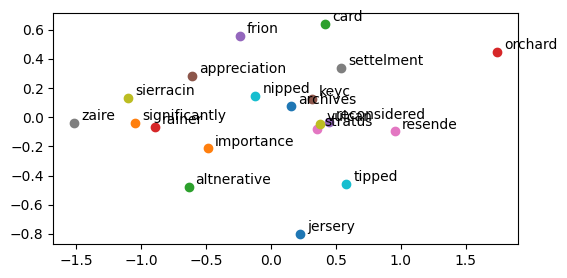

In [42]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocab[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

In [48]:
def get_vector(word):
    with torch.no_grad():
        id_tensor = torch.LongTensor([word2index[word]]).to(device)
        v = model.embedding_v(id_tensor)
        u = model.embedding_u(id_tensor)
        vec = (v + u) / 2
    return vec[0].cpu().numpy()

In [49]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    return dot(a, b) / (norm(a) * norm(b))


In [50]:
cat_vec   = get_vector("cat")
fruit_vec = get_vector("fruit")

print("cat vs fruit:", cos_sim(cat_vec, fruit_vec))


cat vs fruit: -0.6647566
